# Causal Inference and Discovery in Python

## Chapter 06 - Nodes, Edges, and Statistical (In)dependence

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import graphviz
from scipy import stats
import statsmodels.api as sm
from itertools import combinations

plt.style.use('fivethirtyeight')
COLORS = ['#00B0F0','#FF0000']

## Visualizations

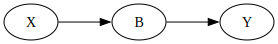

In [3]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'B', 'Y']
positions = ['1,0!', '2.5,0!', '4,0!']

edges = ['XB', 'BY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_06_d_sep_00')

graph

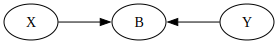

In [4]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'B', 'Y']
positions = ['1,0!', '2.5,0!', '4,0!']

edges = ['XB', 'YB']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_06_d_sep_01')

graph

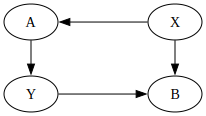

In [5]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'X', 'B', 'Y']
positions = ['1,1!', '3,1!', '3,0!', '1, 0!']

edges = ['XB', 'YB', 'XA', 'AY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_06_d_sep_02')

graph

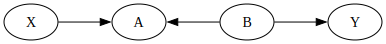

In [6]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'X', 'B', 'Y']
positions = ['1.5,0!', '0,0!', '3,0!', '4.5,0!']

edges = ['XA', 'BA', 'BY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_06_d_sep_03')

graph

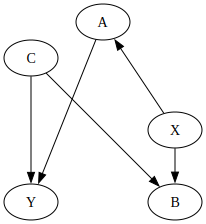

In [7]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'X', 'B', 'Y', 'C']
positions = ['2,2.5!', '3,1!', '3,0!', '1, 0!', '1,2!']

edges = ['XA', 'XB', 'CB', 'CY', 'AY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_06_d_sep_04')

graph

## Estimand first!

In [8]:
# Commute example
t = [22.1, 23.7, 25.2, 20.0, 21.8]

np.mean(t)

22.56

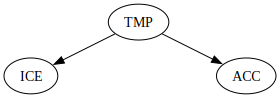

In [9]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['ICE', 'TMP', 'ACC']
positions = ['0,0!', '1.5,.75!', '3,0!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edge('TMP', 'ICE')
graph.edge('TMP', 'ACC')

#graph.render(f'images/ch_06_icecream')

graph

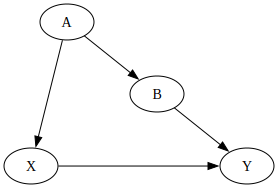

In [10]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Y', 'A', 'B']
positions = ['0,0!', '3,0!', '.5,2!', '1.75,1!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(['XY', 'AX', 'AB', 'BY'])

#graph.render(f'images/ch_06_equivalent_estimands_00')

graph

In [11]:
#?graph.edge

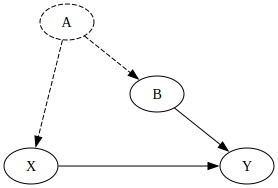

In [12]:
graph = graphviz.Digraph(format='png', engine='neato')


nodes = ['X', 'Y', 'A', 'B']
positions = ['0,0!', '3,0!', '.5,2!', '1.75,1!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('A', style='dashed')

graph.edges(['XY', 'BY'])
graph.edge('A', 'X', style='dashed')
graph.edge('A', 'B', style='dashed')

#graph.render(f'images/ch_06_equivalent_estimands_01')

graph

## Front-door criterion

In [13]:
from dowhy.causal_model import CausalModel

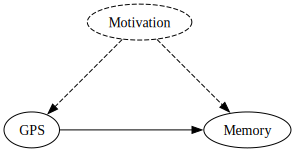

In [14]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['GPS', 'Memory', 'Motivation']
positions = ['0,0!', '3,0!', '1.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('Motivation', style='dashed')

graph.edge('Motivation', 'GPS', style='dashed')
graph.edge('Motivation', 'Memory', style='dashed')
graph.edge('GPS', 'Memory')

#graph.render(f'images/ch_06_gps_01')

graph

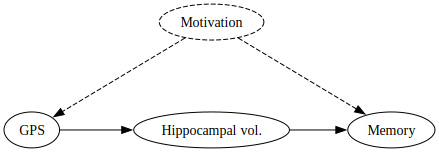

In [15]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['GPS', 'Hippocampal vol.', 'Memory', 'Motivation']
positions = ['0,0!', '2.5,0!', '5,0!', '2.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('Motivation', style='dashed')

graph.edge('Motivation', 'GPS', style='dashed')
graph.edge('Motivation', 'Memory', style='dashed')
graph.edge('GPS', 'Hippocampal vol.')
graph.edge('Hippocampal vol.', 'Memory')

#graph.render(f'images/ch_06_gps_02')

graph

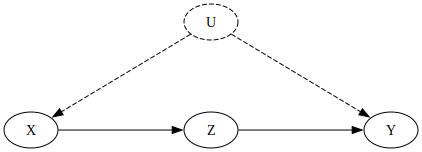

In [16]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Z', 'Y', 'U']
positions = ['0,0!', '2.5,0!', '5,0!', '2.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('U', style='dashed')

graph.edge('U', 'X', style='dashed')
graph.edge('U', 'Y', style='dashed')
graph.edge('X', 'Z')
graph.edge('Z', 'Y')

#graph.render(f'images/ch_06_gps_03')

graph

### Front-door in practice

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [19]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(600)

# Run an experiment
treatments = []
experiment_results = []

# Sample over various treatments
for treatment in np.arange(1, 21):
    gps_hours, hippocampus, memory = scm.intervene(treatment_value=treatment, sample_size=30)
    experiment_results.append(memory)
    treatments.append(gps_hours)

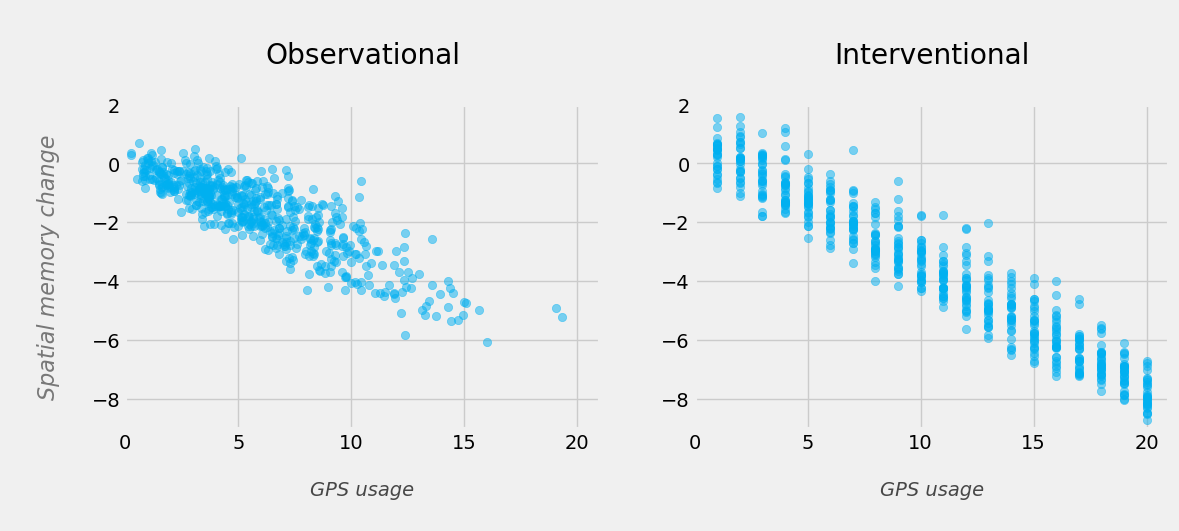

In [20]:
# Plot observational data
plt.figure(figsize=(12, 4))

# Observational
plt.subplot(121)
plt.scatter(gps_obs, memory_obs, alpha=.5, color=COLORS[0])
plt.xlim(0, 21)
plt.ylim(-9, 2)

plt.title('\nObservational\n')
plt.xlabel('\nGPS usage', alpha=.7, fontsize=14, style='italic')
plt.ylabel('\nSpatial memory change\n', alpha=.5, fontsize=16, style='italic')


# Interventional
plt.subplot(122)

plt.scatter(treatments, experiment_results, alpha=.5, color=COLORS[0])
plt.xlim(0, 21)
plt.ylim(-9, 2)

plt.title('\nInterventional\n')
plt.xlabel('\nGPS usage\n', alpha=.7, fontsize=14, style='italic')

plt.show()

### Naive model 1

In [21]:
lr_naive = LinearRegression()
lr_naive.fit(
    X=gps_obs.reshape(-1, 1), 
    y=memory_obs
)

LinearRegression()

### Experimental model

In [22]:
treatments_unpack = np.array(treatments).flatten()
results_unpack = np.array(experiment_results).flatten()

lr_experiment = LinearRegression()
lr_experiment.fit(
    X=treatments_unpack.reshape(-1, 1), 
    y=results_unpack
)

LinearRegression()

In [23]:
X_test = np.arange(1, 21).reshape(-1, 1)

preds_naive = lr_naive.predict(X_test) 
preds_experiment = lr_experiment.predict(X_test)

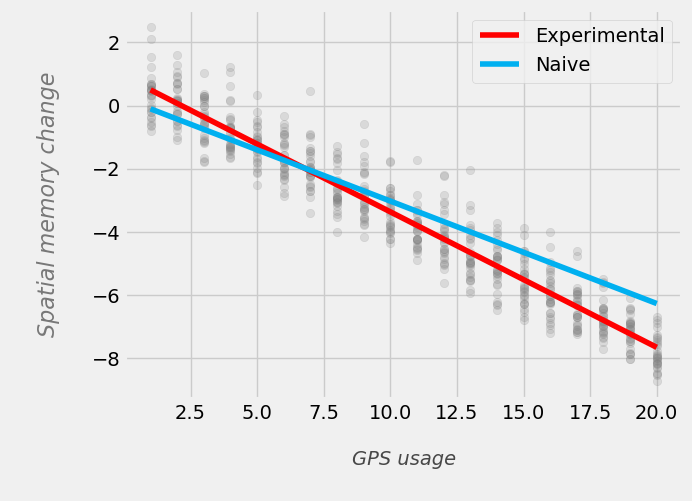

In [24]:
plt.scatter(treatments, experiment_results, alpha=.2, color='gray')
plt.plot(X_test, preds_experiment, label='Experimental', color=COLORS[1])
plt.plot(X_test, preds_naive, label='Naive', color=COLORS[0])

plt.xlabel('\nGPS usage\n', alpha=.7, fontsize=14, style='italic')
plt.ylabel('\nSpatial memory change\n', alpha=.5, fontsize=16, style='italic')

plt.legend()
plt.show()

In [25]:
# Get coefficients
print(f'Naive model:\n{lr_naive.coef_[0]}\n')
print(f'Experiemntal model:\n{lr_experiment.coef_[0]}')

Naive model:
-0.32425535310785975

Experiemntal model:
-0.4288389368918344


## The Linear Bridge to The Causal Promised Land

In [26]:
from dowhy.causal_model import CausalModel
from sklearn.linear_model import LinearRegression

In [27]:
# Model E(Z|X)
lr_zx = LinearRegression()
lr_zx.fit(
    X=gps_obs.reshape(-1, 1),
    y=hippocampus_obs
)

# Model E(Y|X, Z)E(X)
lr_yxz = LinearRegression()
lr_yxz.fit(
    X=np.array([gps_obs,hippocampus_obs]).T,
    y=memory_obs
)

# Compute the expected causal effect
lr_zx.coef_[0] * lr_yxz.coef_[1]

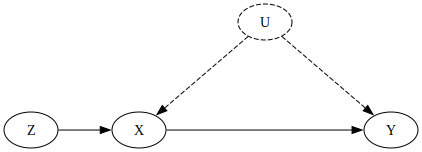

In [28]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['Z', 'X', 'Y', 'U']
positions = ['0,0!', '1.5,0!', '5,0!', '3.25,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('U', style='dashed')

graph.edge('U', 'X', style='dashed')
graph.edge('U', 'Y', style='dashed')
graph.edge('Z', 'X')
graph.edge('X', 'Y')

#graph.render(f'images/ch_06_instrumental_00')

graph

In [29]:
# First, we'll build a structural causal model (SCM)
class InsrumentalSCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_xy = stats.norm()
        self.u_z = stats.norm()
        
    def sample(self, sample_size=100):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_xy = self.u_xy.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        
        z = u_z
        x = 0.7*z + 0.2*u_xy
        y = 0.8*x + 0.1*u_xy
        
        return z, x, y

In [30]:
# Instantiate the SCM and sample
instr_scm = InsrumentalSCM()
z, x, y = instr_scm.sample(1000)

In [31]:
# Fit regression 1
lr_yz = LinearRegression()
lr_yz.fit(X=z.reshape(-1, 1), y=y)

# Fit regression 2
lr_xz = LinearRegression()
lr_xz.fit(X=z.reshape(-1, 1), y=x)

LinearRegression()

In [32]:
# Compute the causal effect
causal_effect = lr_yz.coef_[0] / lr_xz.coef_[0]
causal_effect

In [33]:
# Sanity check
random_z = np.random.randn()

random_z * .7 * .8, random_z * .7 * causal_effect

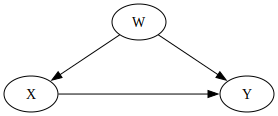

In [34]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'W', 'Y']
positions = ['1,0!', '2.5,1!', '4,0!']

edges = ['XY', 'WY', 'WX']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(r'C:\Users\aleks\OneDrive\Pulpit\BCKDR.png')

graph

## Chapter 07 - The Four-Step Process of Causal Inference

In [35]:
import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

In [36]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Causal models with DoWhy & EconML

### Generate the data

In [37]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [38]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, memory_obs]).T, columns=['X', 'Z', 'Y'])
df

,X,Z,Y
0,10.175909,-6.180603,-2.997135
1,2.458885,-1.349263,-0.349902
2,5.285422,-3.833641,-2.514393
3,1.938704,-1.672054,-0.869401
4,5.377900,-2.314887,-0.405432
...,...,...,...
995,3.337155,-1.788663,-0.749591
996,4.494479,-2.321476,-0.631373
997,10.226159,-5.934922,-2.960297
998,7.738094,-4.626239,-1.931975


### Step 1: Modeling the problem
#### Step 1: Modeling the problem

In [39]:
# Create the graph describing the causal structure
gml_graph = """
graph [
    directed 1
    
    node [
        id "X" 
        label "X"
    ]    
    node [
        id "Z"
        label "Z"
    ]
    node [
        id "Y"
        label "Y"
    ]
    node [
        id "U"
        label "U"
    ]
    
    edge [
        source "X"
        target "Z"
    ]
    edge [
        source "Z"
        target "Y"
    ]
    edge [
        source "U"
        target "X"
    ]
    edge [
        source "U"
        target "Y"
    ]
]
"""

#### Step 1.2 - define the DoWhy model

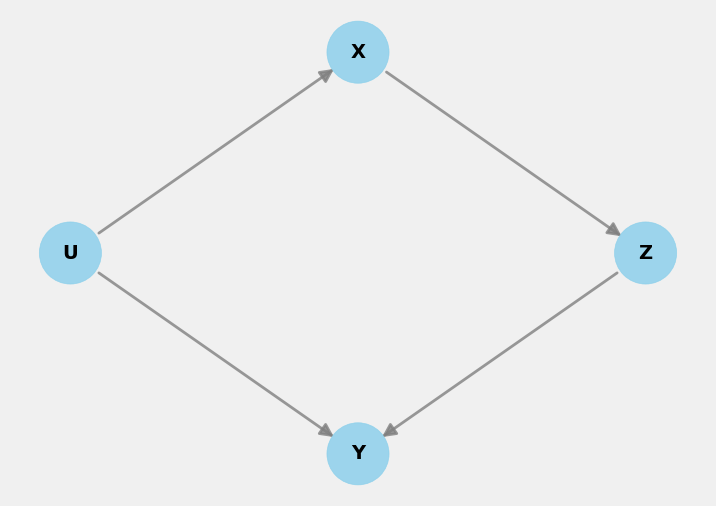

In [40]:
# With graph
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_graph
)

model.view_model()

### Step 2: Identify the estimand

In [41]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)

